In [66]:
import re
import cnfg
import json
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone
from itertools import chain
from collections import Counter, defaultdict

%matplotlib inline
sns.set_style("whitegrid")
params = {'axes.labelsize': 14,
          'axes.labelweight': 'bold',
          'axes.titlesize': 16,
          'figure.titleweight': 'bold'}
plt.rcParams.update(params)

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from nltk.stem.lancaster import LancasterStemmer
from sklearn.metrics import confusion_matrix

## Background

Kiva is a site for crowdfunded microfinance. Kiva allows people to lend money on the internet to low-income entrepreneurs. Loans must be **funded within 30 days** of posting otherwise they become **expired**.

The goal of this project is to build a classifier which predicts which Kiva loans will be funded.

## Initialize Data from DB

In [2]:
config = cnfg.load(".metis_config")
engine = create_engine('postgresql://{}:{}@{}:5432/{}'.format(
            config['db_user'],
            config['db_pwd'],
            config['db_host'],
            'ubuntu'))

conn = engine.connect()
query = 'SELECT * FROM kiva_loan_view'
df = pd.read_sql_query(query, conn)

## Data Train/Test Split

Use stratified sampling to get training and test data from table `loan_view`:
- `X_train`, `X_test`
- `y_train`, `y_test`

Around 8% of loans 'expired' (positive class).

In [3]:
# Get training data X and labels y
y_col = 'status'
X_columns = df.columns.drop([y_col])
X = df.loc[:, X_columns]

# Expired Status = Positive Class (i.e. y=1)
y_status = df[y_col] 
y = y_status.map(lambda status: 1 if (status == 'expired') else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=55)

# Check if stratified K-Fold sampling worked correctly
train_data_count = y_train.shape[0]
test_data_count = y_test.shape[0]

print("""# Training points: {}, # Test points: {}
% Loans expired in training data: {}
% Loans expired in test data: {}""".format(
    train_data_count, test_data_count,
    y_train[y_train == 1].shape[0] * 100 / train_data_count,
    y_test[y_test == 1].shape[0] * 100 / test_data_count)
)

# Training points: 63551, # Test points: 21184
% Loans expired in training data: 8.053374455161995
% Loans expired in test data: 8.053247734138973


## Data Exploration

### Existing Features

Don't use features `funded_date`, `funded_amount`, and `lender_count` because these would cause data leakage.

In [4]:
X_train.columns.values

array(['id', 'name', 'funded_amount', 'funded_date',
       'planned_expiration_date', 'posted_date', 'sector', 'activity',
       'loan_amount', 'lender_count', 'country', 'country_code', 'town',
       'latitude', 'longitude', 'bonus_credit_eligibility', 'description',
       'use_text', 'tag_text', 'terms_disbursal_amount',
       'terms_disbursal_currency', 'terms_disbursal_date',
       'terms_loan_amount', 'terms_loss_liability_nonpayment',
       'terms_repayment_term', 'journal_totals_entries', 'borrower_count',
       'm_borrower_count', 'f_borrower_count', 'pic_borrower_count'], dtype=object)

### Data Distribution

Remove outliers where loan amount > $10000 and loan length > 100 months. 

In [5]:
X_train.describe()

,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000


In [6]:
# Outliers
len(X_train[X_train.loan_amount > 10000]), len(X_train[X_train.terms_repayment_term > 100])

(15, 24)

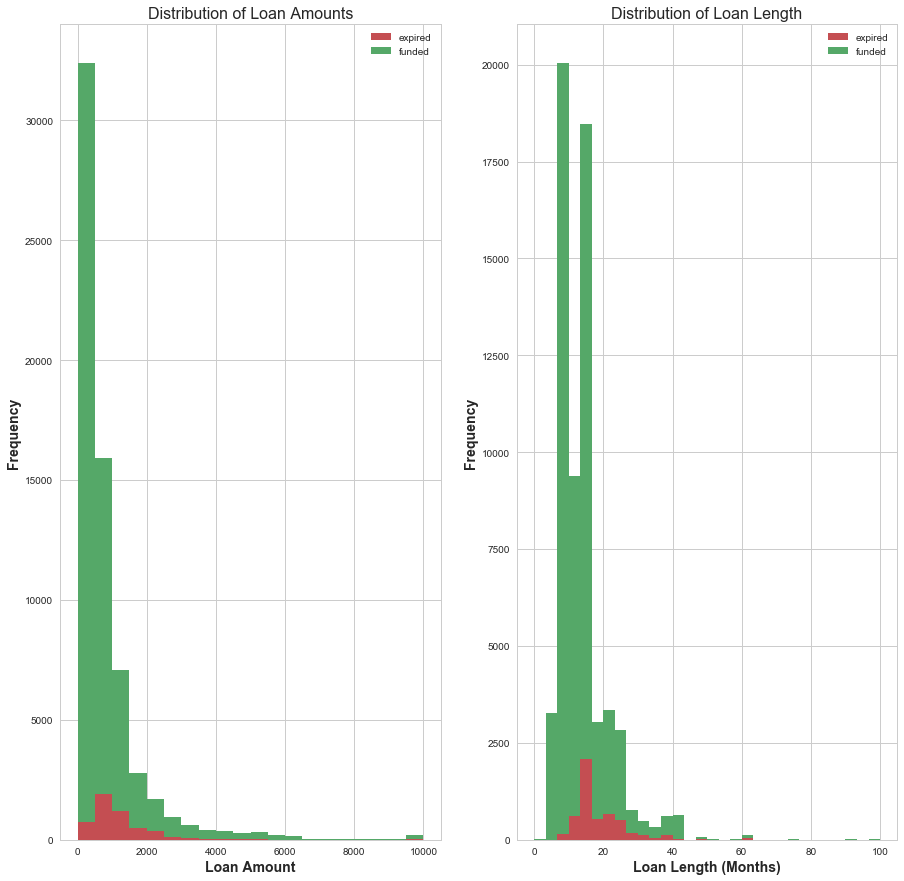

In [7]:
def initial_data_explore(data_expired, data_funded):
    """
    Plot frequencies vs features grouped by expired or funded status
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))

    # Loan Amounts
    pd.DataFrame({
        'expired': data_expired.loan_amount,
        'funded': data_funded.loan_amount
    }).plot.hist(ax=ax[0], stacked=True, bins=20,
                 color=['#c44e52', '#55a868'], range=(0,10000))

    ax[0].set_title('Distribution of Loan Amounts')
    ax[0].set_ylabel('Frequency')
    ax[0].set_xlabel('Loan Amount')

    # Loan Length (Repayment Term)
    pd.DataFrame({
        'expired': data_expired[~np.isnan(data_expired.repayment_term)].repayment_term,
        'funded': data_funded[~np.isnan(data_funded.repayment_term)].repayment_term
    }).plot.hist(ax=ax[1], stacked=True, bins=30, range=(0,100),
                 color=['#c44e52', '#55a868'])

    ax[1].set_title('Distribution of Loan Length')
    ax[1].set_ylabel('Frequency')
    ax[1].set_xlabel('Loan Length (Months)')

train_status = pd.DataFrame({'loan_amount': X_train.loan_amount,
                             'repayment_term': X_train.terms_repayment_term,
                             'country': X_train.country,
                             'sector': X_train.sector, 
                             'activity': X_train.activity, 
                             'status': y_train})

train_expired = train_status.groupby('status').get_group(1)
train_funded = train_status.groupby('status').get_group(0)

initial_data_explore(train_expired, train_funded)

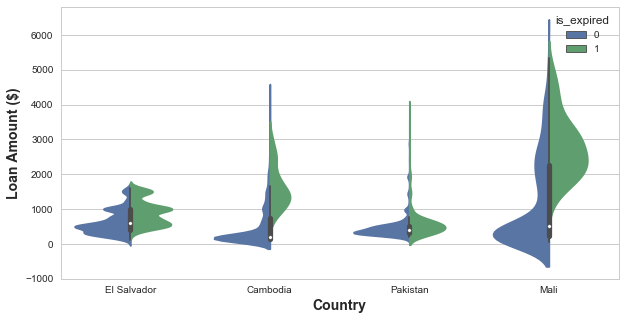

In [8]:
def plot_expiration_by_country():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    train_Xy = pd.concat([X_train, pd.DataFrame({'is_expired': y_train})], axis=1)
    train_Xy_country = train_Xy.loc[(train_Xy.country == 'Pakistan') | (train_Xy.country == 'Mali') 
                                    | (train_Xy.country == 'Cambodia') | (train_Xy.country == 'El Salvador'), :]
    sns.violinplot(x="country", y="loan_amount", hue="is_expired", data=train_Xy_country, split=True, ax=ax);
    ax.set_ylabel('Loan Amount ($)')
    ax.set_xlabel('Country')
    
plot_expiration_by_country()

## Data Cleaning & Feature Engineering

### NLP Features

Some Kiva loans have tags in their listings. E.g. 'education', 'female', etc.
See if having these tags helps to get funding.

Calculate `tag_max_idf` and `tag_min_idf` to see whether having more popular or less popular tags affect expiration.

In [16]:
#X_train['text_tag_clean'] = X_train['tag_text'].str.strip()
tokenizer_regex = re.compile(r"[\s]")

def tokenize(text):
    clean_text = re.sub(r'[,!.$\d%&~?()#<>"=/-]', ' ', text)
    clean_text = ' '.join(clean_text.split())
    tokens = [tok.strip().lower() for tok in tokenizer_regex.split(clean_text)]
    return list(tokens)


def get_tag_idf_score():
    """
    Returns IDF score for each tag
    """
    # Array of funded loans' tags
    docs = X_train.loc[(y_train==0), 'tag_text'].as_matrix()
    
    tfidf = TfidfVectorizer(stop_words=frozenset(), tokenizer=tokenize, ngram_range=(1,1))
    tfidf.fit(docs)
    
    word_idf_score = {}
    for vocab, vocab_index in tfidf.vocabulary_.items():
        word_idf_score[vocab] = tfidf.idf_[vocab_index]
    return word_idf_score

tag2idf = get_tag_idf_score()

In [17]:
def add_loan_min_max_idf_tag(row):
    tag_text = row['tag_text']
    tags = tokenize(tag_text)
    loan_tags2idf = sorted([tag2idf[tag] for tag in tags])
    row['tag_max_idf'] = loan_tags2idf[-1] or 0
    row['tag_min_idf'] = loan_tags2idf[0] or 0
    return row

### Loan Count and Expiration Percentage by Sector, Activity & Country

Define variables 
- `df_status_country`: Loan Count and % Expired by Sector
- `df_status_sector`: Loan Count and % Expired by Country
- `df_status_activity`: Loan Count and % Expired by Activity
- `train_medians`: Impute median into columns with missing records

In [18]:
def get_loan_status(data_status, groupby_feature):
    """Get loan count and percent expired by sector, country, etc in data"""
    df_status_by_feature = data_status.groupby(['status', groupby_feature]).count().reset_index()
    df_status_by_feature = df_status_by_feature.pivot(index=groupby_feature, columns='status', values='loan_amount')
    df_status_by_feature = df_status_by_feature.fillna(0).reset_index()
    df_status_by_feature = df_status_by_feature.set_index([groupby_feature])
    df_status_by_feature['total_loan_count'] = df_status_by_feature[0] + df_status_by_feature[1]
    df_status_by_feature['percent_expired'] =  df_status_by_feature[1] / df_status_by_feature['total_loan_count']
    return df_status_by_feature

df_status_sector = get_loan_status(train_status, 'sector')
df_status_country = get_loan_status(train_status, 'country')
df_status_activity = get_loan_status(train_status, 'activity')

In [19]:
df_status_sector.head(n=3) # Sector

status,0,1,total_loan_count,percent_expired
sector,,,,
Agriculture,16483.0,1654.0,18137.0,0.091195
Arts,1212.0,6.0,1218.0,0.004926
Clothing,2657.0,350.0,3007.0,0.116395


In [20]:
df_status_activity.head(n=3) # Activity

status,0,1,total_loan_count,percent_expired
activity,,,,
Agriculture,1723.0,251.0,1974.0,0.127153
Air Conditioning,6.0,0.0,6.0,0.000000
Animal Sales,903.0,61.0,964.0,0.063278


In [21]:
df_status_country.head(n=3) # Country

status,0,1,total_loan_count,percent_expired
country,,,,
Albania,124.0,27.0,151.0,0.178808
Armenia,779.0,281.0,1060.0,0.265094
Azerbaijan,125.0,21.0,146.0,0.143836


In [22]:
def loan_clean_engineer(row):
    """Add new fields 
    `already_disbursed`, `percentage_women`, `sector_percent_expired`, `activity_percent_expired`,
    `country_percent_expired`, `country_total_loans`, `description_word_count`, `tag_max_idf` and `tag_min_idf`
    """
    
    row['already_disbursed'] = False
    
    if row.terms_disbursal_date and (row.posted_date >= row.terms_disbursal_date):
        row.already_disbursed = True
    
    # Percentage of Women Borrowers
    row['percentage_women'] = 0
    if row.f_borrower_count > 0:
        row.percentage_women = 100 * (row.f_borrower_count / row.borrower_count)
    
    # Sector's Median Expiration Percentage
    sector = row.sector
    row['sector_percent_expired'] = df_status_sector['percent_expired'].get(sector, None)
    
    # Activity's Median Expiration Percentage
    sector = row.sector
    row['activity_percent_expired'] = df_status_sector['percent_expired'].get(sector, None)

    # Country's Median Expiration Percentage
    country = row.country
    row['country_percent_expired'] = df_status_country['percent_expired'].get(country, None)
        
    # Country's Total Loan Count
    row['country_total_loans'] = df_status_country['total_loan_count'].get(country, None)
    
    # Number of Words in Description
    row['description_word_count'] = 0 # default length = 0
    if (row.description):
        row['description_word_count'] = len(row.description.split(' '))
        
    # See if loan contains tags that are indicitive of funding
    add_loan_min_max_idf_tag(row)
  
    return row

def clean_engineer_dataset(data_df):
    data_df = data_df.apply(loan_clean_engineer, axis=1)
    return data_df

X_train = clean_engineer_dataset(X_train)

# Only impute test set with training data
X_test = clean_engineer_dataset(X_test) 

In [23]:
X_train.describe()

,id,funded_amount,loan_amount,lender_count,latitude,longitude,terms_disbursal_amount,terms_loan_amount,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count,percentage_women,sector_percent_expired,activity_percent_expired,country_percent_expired,country_total_loans,description_word_count,tag_max_idf,tag_min_idf
count,6.355100e+04,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,6.355100e+04,63551.000000,63551.000000,63551.0,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000,63551.000000
mean,1.086020e+06,763.520244,819.767195,20.073516,10.658339,33.646768,1.189249e+06,819.767195,13.575270,0.0,1.980567,0.399569,1.580998,1.948577,77.116290,0.080534,0.080534,0.080534,5726.175560,120.522572,3.369987,2.307104
std,3.079779e+04,1113.542627,1151.308639,26.982058,14.823680,80.499433,5.585610e+06,1151.308639,7.945217,0.0,3.200214,1.040144,2.891592,3.059185,40.633814,0.029015,0.029015,0.070279,6273.019041,52.103303,0.932039,0.543461
min,1.017905e+06,0.000000,25.000000,0.000000,-30.000000,-172.616667,1.000000e+02,25.000000,2.000000,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.909027,1.909027
25%,1.057834e+06,250.000000,275.000000,7.000000,1.000000,-57.996389,5.500000e+03,275.000000,8.000000,0.0,1.000000,0.000000,1.000000,1.000000,78.260870,0.071584,0.071584,0.020401,933.000000,85.000000,2.768819,1.909027
50%,1.092222e+06,425.000000,475.000000,12.000000,13.000000,38.000000,2.000000e+04,475.000000,13.000000,0.0,1.000000,0.000000,1.000000,1.000000,100.000000,0.091195,0.091195,0.057878,2477.000000,108.000000,3.227507,1.994048
75%,1.113756e+06,825.000000,925.000000,23.000000,13.833333,122.000000,1.000000e+05,925.000000,14.000000,0.0,1.000000,1.000000,1.000000,1.000000,100.000000,0.092048,0.092048,0.116331,16127.000000,145.000000,3.674132,2.768819
max,1.140926e+06,50000.000000,50000.000000,1626.000000,49.783333,159.000000,1.300000e+08,50000.000000,145.000000,0.0,44.000000,28.000000,41.000000,44.000000,100.000000,0.138451,0.138451,0.265094,16127.000000,825.000000,7.685194,7.390686


In [24]:
test_case = X_train.head(n=1)
test_case

,id,name,funded_amount,funded_date,planned_expiration_date,posted_date,sector,activity,loan_amount,lender_count,country,country_code,town,latitude,longitude,bonus_credit_eligibility,description,use_text,tag_text,terms_disbursal_amount,terms_disbursal_currency,terms_disbursal_date,terms_loan_amount,terms_loss_liability_nonpayment,terms_repayment_term,journal_totals_entries,borrower_count,m_borrower_count,f_borrower_count,pic_borrower_count,already_disbursed,percentage_women,sector_percent_expired,activity_percent_expired,country_percent_expired,country_total_loans,description_word_count,tag_max_idf,tag_min_idf
80485,1131911,Augustine,400,2016-08-23 01:04:44,2016-09-19 17:10:07,2016-08-20 17:10:07,Retail,Bookstore,400,15,Ghana,GH,Kaneshie,8.0,-2.0,False,Augustine is 55 years old. He is married and has a 27-year-old child. He owns a bookshop and sells books and stationery near the Kaneshie's cluster of schools. He has been in the bookshop business for the past eight years.\r\n\r\nAugustine’s major business challenge is inadequate capital to buy more books and stationery to sell. He needs a loan to buy more books and stationery so that he can sell to the school children. Augustine uses the profit he makes from the business to fend for his family. He hopes and dreams to expand the business in the next five years.\r\n\r\nThank you to Kiva lenders for supporting Augustine’s business! \r\n,to buy books and stationery to sell.,user_favorite #Elderly,1500,GHS,2016-11-09 08:00:00,400,lender,10,0,1,1,0,1,False,0.0,0.092048,0.092048,0.044231,520.0,109,2.839498,2.111686


## Post Data-Engineering Analysis


In [25]:
print('All columns (including engineered features): {}'.format(X_train.columns.values))

All columns (including engineered features): ['id' 'name' 'funded_amount' 'funded_date' 'planned_expiration_date'
 'posted_date' 'sector' 'activity' 'loan_amount' 'lender_count' 'country'
 'country_code' 'town' 'latitude' 'longitude' 'bonus_credit_eligibility'
 'description' 'use_text' 'tag_text' 'terms_disbursal_amount'
 'terms_disbursal_currency' 'terms_disbursal_date' 'terms_loan_amount'
 'terms_loss_liability_nonpayment' 'terms_repayment_term'
 'journal_totals_entries' 'borrower_count' 'm_borrower_count'
 'f_borrower_count' 'pic_borrower_count' 'already_disbursed'
 'percentage_women' 'sector_percent_expired' 'activity_percent_expired'
 'country_percent_expired' 'country_total_loans' 'description_word_count'
 'tag_max_idf' 'tag_min_idf']


In [26]:
def plot_expiration_rate_by_feature(feature, x_label, range_x):
    """
    See how expiration rate changes with features 
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 15)) 
    # Frequency of feature for loans
    count0, bins_0, _ = ax[0].hist(X_train.loc[(y_train==0), feature], bins=10, 
                                   label='Funded', range=range_x, color='#55a868')
    count1, bins_1, _ = ax[0].hist(X_train.loc[(y_train==1), feature], bins=10, 
                                   label='Expired', range=range_x, color='#c44e52' )
    ax[0].set_xlabel(x_label)
    ax[0].set_ylabel('Frequency')
    ax[0].legend()
    
    sns.regplot((bins_0[:-1]+bins_0[1:])/2, count1/(count1 + count0), ax=ax[1])
    ax[1].set_ylabel('Fraction of Expired Loans', fontsize=20)
    ax[1].set_xlabel(x_label)

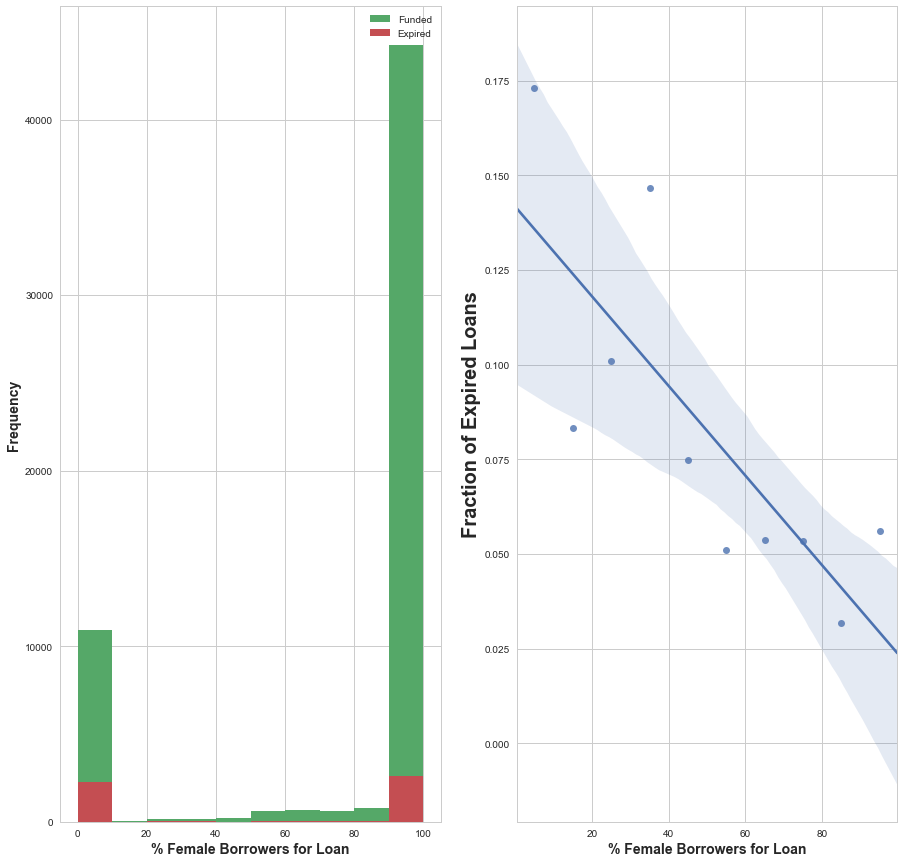

In [27]:
plot_expiration_rate_by_feature('percentage_women', '% Female Borrowers for Loan', (0,100))

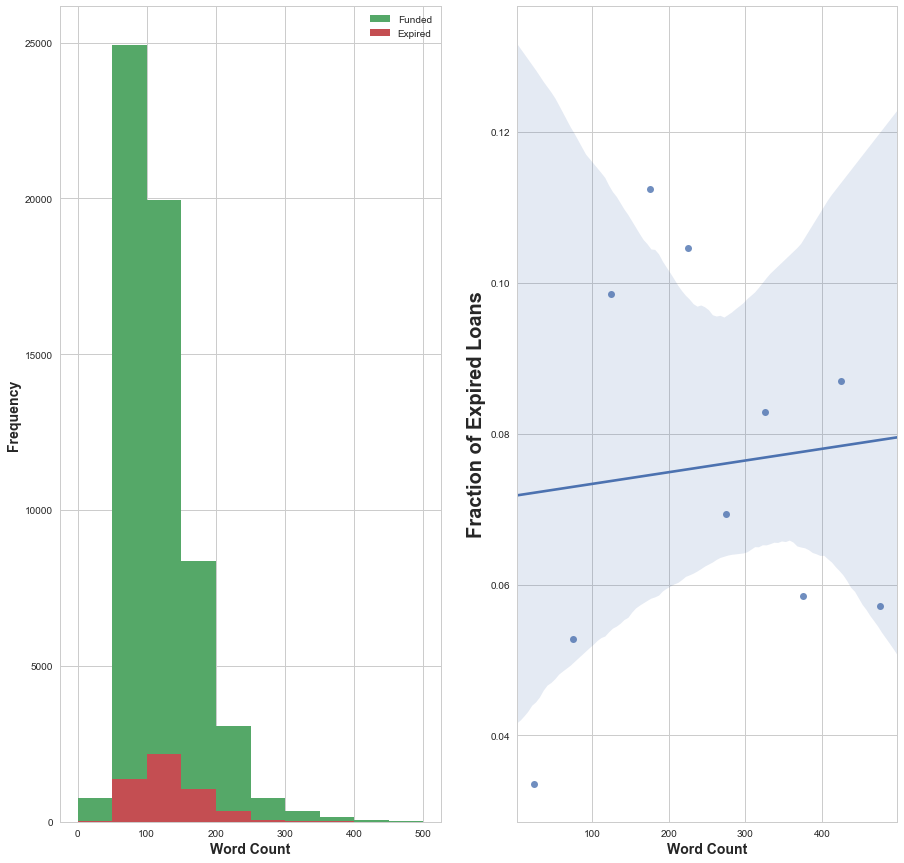

In [28]:
plot_expiration_rate_by_feature('description_word_count', 'Word Count', (0, 500))

## Helper Functions

In [29]:
def order_zip_coeff(coeff_names, coeff_vals):
    coeff_names = np.array(coeff_names)
    coeff_vals = np.array(coeff_vals)
    importance_indices = np.argsort(coeff_vals)[::-1]
    return list(enumerate(zip(coeff_names[importance_indices], coeff_vals[importance_indices])))


def cross_val_predict_proba(model, X, y, folds=5, verbose=True):
    """
    Function like “cross_val_predict” except using `predict_proba`. 
    May be useful to do cross-validation or grid-search, but using ROC_AUC 
    instead of accuracy or some other metric.
    
    Returns y_proba based on cross_validated train set
    """
    this_model = clone(model)
    num_classes = len(np.unique(y))
    y_pred = np.zeros((len(y),num_classes))
    skf = StratifiedKFold(n_splits=folds, shuffle=True).split(X, y)
    for idx, (train_idx, test_idx) in enumerate(skf):
        if verbose:
            print("training fold {} of {}".format(idx+1, folds))
        X_train = np.array(X)[train_idx,:]
        X_test = np.array(X)[test_idx,:]
        y_train = np.array(y)[train_idx]        
        this_model.fit(X_train,y_train)
        y_pred[test_idx,:] = this_model.predict_proba(X_test)
    return y_pred

def metric_curves(truthvec, scorevec, digit_prec=2):
    """
    Draw multiple metric curves on same graph
    
    truthvec = y_actual_test, 
    scorevec = y_pred_proba
    """
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)
    
    accuracyvec = np.zeros(numthresh)
    
    for i in range(numthresh):
        thresh = threshvec[i]
        pos_pred = (scorevec >= thresh)
        neg_pred = (scorevec < thresh)
        tpvec[i] = sum(truthvec[pos_pred])
        fpvec[i] = sum(1 - truthvec[pos_pred])
        fnvec[i] = sum(truthvec[neg_pred])
        
        # prediction changes with every threshold
        predvec = [1 if pred_pos else 0 for pred_pos in pos_pred]
        accuracyvec[i] = accuracy_score(truthvec, predvec)
        
    recallvec = tpvec / (tpvec + fnvec)
    precisionvec = tpvec / (tpvec + fpvec)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Precision vs Thresholds and Recall vs Thresholds
    ax.plot(threshvec, precisionvec, label='Precision')
    ax.plot(threshvec, recallvec, label='Recall')
    ax.plot(threshvec, accuracyvec, label='Accuracy')

    ax.axis([0, 1, 0, 1])
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Precision / Recall / Accuracy")
    ax.legend()
    
    return (recallvec, precisionvec, threshvec)

def print_metrics(model_name, y_actual_test, y_pred_proba):
    auc_score = roc_auc_score(y_actual_test, y_pred_proba)
    l_loss = log_loss(y_actual_test, y_pred_proba)
    print('--- ', model_name, ' ---')
    print('AUC: ', auc_score)
    print('Log Loss: ', l_loss)
    recallvec, precisionvec, threshvec = metric_curves(y_actual_test, y_pred_proba, digit_prec=2)
    return (recallvec, precisionvec, threshvec, auc_score, l_loss)
    

In [30]:
def example_calc():
    pos_pred = np.array([True, False, True, False])
    truthvec = np.array([1, 0, 0, 1])
    tpvec = truthvec[pos_pred]
    fpvec = 1 - tpvec
    
    neg_pred = np.array([False, True, False, True]) # Opposite
    fnvec = truthvec[neg_pred]
    print('Predicted positives (Indices 0, 2):', tpvec, ', Actual Pos (Indice 0), ', 'True Pos Count: ', sum(tpvec))
    print('False positives: ', fpvec, '(Indice 2), False Pos Count: ', sum(fpvec))
    print('False negatives: ', fnvec, '(Indices 1, 3), False Neg Count: ', sum(fnvec))
example_calc()    

Predicted positives (Indices 0, 2): [1 0] , Actual Pos (Indice 0),  True Pos Count:  1
False positives:  [0 1] (Indice 2), False Pos Count:  1
False negatives:  [0 1] (Indices 1, 3), False Neg Count:  1


## Stemming

In [80]:
stemmer = LancasterStemmer()
stemmer.stem('Naivety')

'naiv'

## Naive Bayes & Tags

In [31]:
def get_tag_tfidf():
    """
    Returns TF_IDF Score for Tags
    """
    # Array of funded loans' tags
    docs = X_train.tag_text
    
    tfidf = TfidfVectorizer(stop_words=frozenset(), tokenizer=tokenize, ngram_range=(1,1))
    docs_tfidf = tfidf.fit_transform(docs)
   
    return tfidf, docs_tfidf

tags_tfidf_vectorizer, X_train_tags_tfidf = get_tag_tfidf()
X_test_tags_tfidf = tags_tfidf_vectorizer.transform(X_test.tag_text)

nb_model_tags = BernoulliNB().fit(X_train_tags_tfidf, y_train)
y_test_predict_proba_nb_tags = nb_model_tags.predict_proba(X_test_tags_tfidf)[:, 1]

X_train['nb_tag_prob'] = nb_model_tags.predict_proba(X_train_tags_tfidf)[:,1]
X_test['nb_tag_prob'] = y_test_predict_proba_nb_tags

In [62]:
X_test_highest_prob_arg_tag = np.argsort(y_test_predict_proba_nb_tags)[-10:-1]
X_test.iloc[X_test_highest_prob_arg_tag]['tag_text']

74565    #Woman Owned Biz #Vegan #Parent #Biz Durable Asset #Trees #Repair Renew Replace                              
74516    #Woman Owned Biz #Vegan #Parent #Biz Durable Asset #Trees #Repair Renew Replace                              
73620    #Woman Owned Biz #Vegan #Parent #Biz Durable Asset #Trees #Repair Renew Replace                              
73701    #Woman Owned Biz #Vegan #Parent #Repeat Borrower #Biz Durable Asset #Repair Renew Replace                    
74677    user_favorite #First Loan #Vegan #Parent #Biz Durable Asset #Repair Renew Replace                            
39876    user_favorite #Woman Owned Biz #Parent #Supporting Family #Biz Durable Asset #Repair Renew Replace           
55545    user_favorite #Parent #Schooling #Repeat Borrower #Supporting Family #Biz Durable Asset #Repair Renew Replace
83424    #First Loan #Parent #Supporting Family #Biz Durable Asset #Repair Renew Replace                              
47933    user_favorite #Woman Owned Biz #Single 

## Naive Bayes & Bag of Words

In [33]:
def get_docs_vocab(docs):
    count_vectorizer = CountVectorizer(ngram_range=(2,2),  
                                       stop_words=frozenset(), 
                                       tokenizer=tokenize)
    doc_term_counts = count_vectorizer.fit_transform(docs)
    # vocab = count_vectorizer.vocabulary_.keys()
    return doc_term_counts, count_vectorizer

def get_description_tfidf(docs):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),  
                                       stop_words=stop_words.ENGLISH_STOP_WORDS, 
                                       tokenizer=tokenize)
    doc_term_tfidf = tfidf_vectorizer.fit_transform(docs)
    # vocab = tfidf_vectorizer.vocabulary_.keys()
    return doc_term_tfidf, tfidf_vectorizer

X_train_description_tfidf, description_tfidf_vectorizer = get_description_tfidf(X_train.description)
X_test_description_tfidf = description_tfidf_vectorizer.transform(X_test.description)
nb_model = BernoulliNB().fit(X_train_description_tfidf, y_train)
y_test_predict_proba_nb = nb_model.predict_proba(X_test_description_tfidf)[:, 1]

X_train['nb_prob'] = nb_model.predict_proba(X_train_description_tfidf)[:,1]
X_test['nb_prob'] = y_test_predict_proba_nb

In [34]:
X_train_description_tfidf.shape

(63551, 61883)

In [35]:
X_test_description_tfidf.shape

(21184, 61883)

In [36]:
nb_model.classes_

array([0, 1])

In [37]:
y_test_predict_proba_nb

array([  2.21423869e-16,   7.24253698e-14,   8.52184434e-07, ...,
         9.99498647e-01,   5.69181047e-03,   1.75560392e-09])

In [38]:
# Get description with highest probabilities
X_test_highest_prob_arg = np.argsort(y_test_predict_proba_nb)[-2:-1]
X_test.iloc[X_test_highest_prob_arg]['description']

38402    Hamisu is a Babban Gona maize farmer from Kinkiba village. He is married with 17 children and lives in a mud house with his family. He is a meticulous farmer who has invested time and resources in his farm. He hopes his children work twice as hard as he has and become doctors.<br /> <br />Thanks to his drive, Hamisu is able to ensure that his family eats three square meals a day. In order for Hamisu to keep improving his yield, and as a result feed his family, he needs access to high-quality inputs such as fertilizers, herbicides and improved seeds. As a Babban Gona member, Hamisu will be provided with a full suite of the best inputs to optimize his farm and increase his yields up to 3.5 metric tones per hectare; 2.3 times the national average.<br /> <br />With increased yields and income of up to 3.5 times the national average, Hamisu looks forward to using his additional income to pay his children's school fees. Hamisu is a happy Babban Gona farmer and holds good yields as h

---  Model Naive Bayes  ---
AUC:  0.777351175168
Log Loss:  1.30256442603


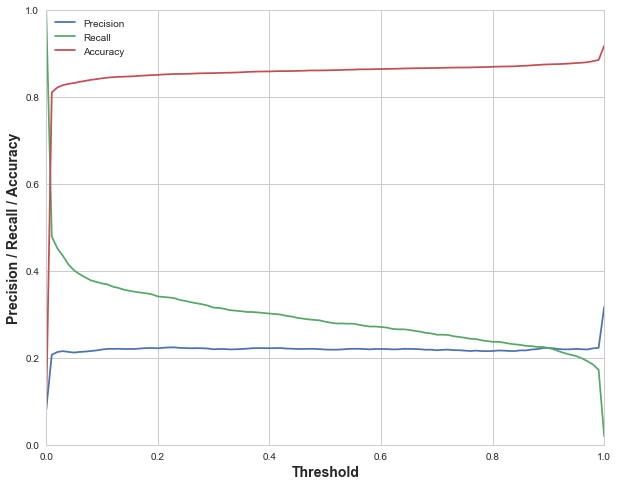

In [39]:
model_name_nb = 'Model Naive Bayes'
recallvec_nb, precisionvec_nb, threshvec_nb, auc_score_nb, l_loss_nb = print_metrics (
    model_name_nb, y_test, y_test_predict_proba_nb)

### LSA Topics
Project the tfidf vectors onto the first N principal components.
Though this is significantly fewer features than the<br/>
original tfidf vector, they are stronger features, and the accuracy is higher.

In [40]:
lsa_topic_count = 200
lsa = TruncatedSVD(lsa_topic_count, algorithm='randomized')
X_train_lsa = lsa.fit_transform(X_train_description_tfidf)

In [41]:
explained_variance = lsa.explained_variance_ratio_.sum()
explained_variance

0.27449139470854761

In [42]:
lsa.components_.shape

(200, 61883)

In [43]:
# Now apply the transformations to the test data as well.
X_test_lsa = lsa.transform(X_test_description_tfidf)

In [44]:
X_test_lsa.shape

(21184, 200)

## Naive Bayes & LSA Topics

In [45]:
nb_model_lsa = BernoulliNB().fit(X_train_lsa, y_train)
y_test_predict_proba_nb_lsa = nb_model_lsa.predict_proba(X_test_lsa)[:, 1]
y_train_predict_proba_nb_lsa = nb_model_lsa.predict_proba(X_train_lsa)[:, 1]

X_train['nb_lsa_prob'] = y_train_predict_proba_nb_lsa
X_test['nb_lsa_prob'] = y_test_predict_proba_nb_lsa

## k-NN
Use k-NN as a feature input to another model to capture interaction effects. k-NN suffers heavily from curse of dimensionality so only use 3 features.

Fitted k=70, Log Loss: 0.2488457028150716
Fitted k=72, Log Loss: 0.24006759307451753
Fitted k=74, Log Loss: 0.2403975706948542
Fitted k=76, Log Loss: 0.23798652106093424
Fitted k=78, Log Loss: 0.24363632724183437
Fitted k=80, Log Loss: 0.2284068526241215
Fitted k=82, Log Loss: 0.23445867750406185
Fitted k=84, Log Loss: 0.23142695845861247
Fitted k=86, Log Loss: 0.2298099265709972
Fitted k=88, Log Loss: 0.23782219289467363
Fitted k=90, Log Loss: 0.23431516114010967
Fitted k=92, Log Loss: 0.23089433415115712
Fitted k=94, Log Loss: 0.23117222558792822
Fitted k=96, Log Loss: 0.22819646315111017
Fitted k=98, Log Loss: 0.23957795459502532
Fitted k=100, Log Loss: 0.2265014047298858
Fitted k=102, Log Loss: 0.22395213296665084
Fitted k=104, Log Loss: 0.225821906869907
Fitted k=106, Log Loss: 0.22572317923063764
Fitted k=108, Log Loss: 0.22257040186750984
Fitted k=110, Log Loss: 0.2291667731667829
Fitted k=112, Log Loss: 0.2217994311001004
Fitted k=114, Log Loss: 0.22973734518966257
Fitted k=116

[(112, 0.22179943110010039),
 (108, 0.22257040186750984),
 (116, 0.22317767823942583),
 (118, 0.22351352172218841),
 (102, 0.22395213296665084),
 (106, 0.22572317923063764),
 (104, 0.225821906869907),
 (100, 0.22650140472988581),
 (96, 0.22819646315111017),
 (80, 0.2284068526241215)]

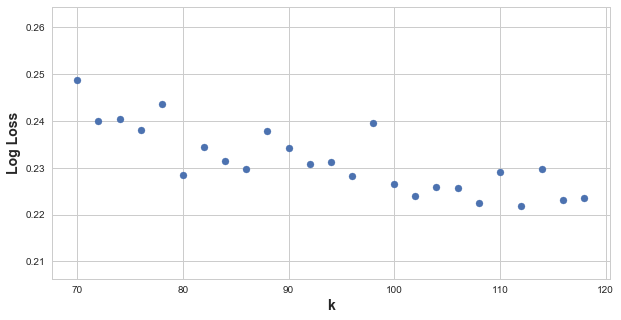

In [48]:
knn_cols = ['loan_amount',  'latitude', 'longitude']
std_knn = StandardScaler()
std_knn.fit(X_train.loc[:, knn_cols])

X_std_train_knn = std_knn.transform(X_train.loc[:, knn_cols])
X_std_test_knn = std_knn.transform(X_test.loc[:, knn_cols])

def plot_k_vs_logloss():
    """See which value of `k` givest the lowest log loss"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
    knn_log_loss_scores = []
    k_range = range(70, 120, 2)
    for k in k_range:
        knn_model_k = KNeighborsClassifier(n_neighbors=k)
        y_cross_val_pred_proba_knn = cross_val_predict_proba(knn_model_k, X_std_train_knn, y_train, verbose=False)[:, 1]
        k_log_loss = log_loss(y_train, y_cross_val_pred_proba_knn)
        print('Fitted k={}, Log Loss: {}'.format(k, k_log_loss))
        knn_log_loss_scores.append((k, k_log_loss))

    ax.scatter(k_range, [log_loss for knn, log_loss in knn_log_loss_scores])
    ax.set_xlabel('k')
    ax.set_ylabel('Log Loss')
    knn_log_loss_scores.sort(key=lambda x: x[1], reverse=False)
    return knn_log_loss_scores[:10]

plot_k_vs_logloss()

---  KNN, K=98  ---
AUC:  0.841402035085
Log Loss:  0.230180068858


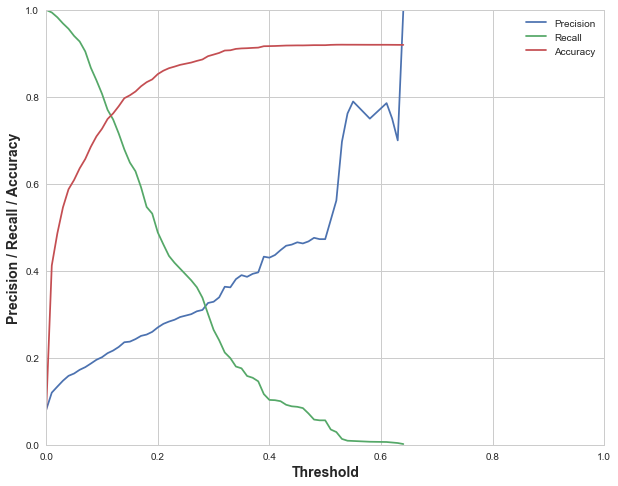

In [49]:
k_final = 98
knn_model = KNeighborsClassifier(n_neighbors=k_final)
knn_model.fit(X_std_train_knn, y_train)
y_test_pred_proba_knn = knn_model.predict_proba(X_std_test_knn)[:, 1]

model_name_knn = 'KNN, K={}'.format(k_final)
recallvec_knn, precisionvec_knn, threshvec_knn, auc_score_knn, l_loss_knn = print_metrics (
    model_name_knn, y_test, y_test_pred_proba_knn)

### Use k-NN Probability Prediction as a Feature

In [50]:
y_train_pred_proba_knn = knn_model.predict_proba(X_std_train_knn)[:, 1]

# Add new column `knn_pred`
X_train['knn_pred'] = y_train_pred_proba_knn
X_test['knn_pred'] = y_test_pred_proba_knn

## Random Forest

---  Random Forest  ---
AUC:  0.901838422451
Log Loss:  0.188753804439


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


[(0, ('nb_prob', 0.17216481075759091)),
 (1, ('description_word_count', 0.13804268525511312)),
 (2, ('knn_pred', 0.13456847810726955)),
 (3, ('nb_tag_prob', 0.099579011200268949)),
 (4, ('loan_amount', 0.082960259953958324)),
 (5, ('terms_repayment_term', 0.06491560395400825)),
 (6, ('tag_max_idf', 0.057458711446342577)),
 (7, ('longitude', 0.033622827293158748)),
 (8, ('latitude', 0.032847282665912601)),
 (9, ('sector_percent_expired', 0.032451222385900265)),
 (10, ('activity_percent_expired', 0.032318919737169452)),
 (11, ('country_percent_expired', 0.031321135504587809)),
 (12, ('tag_min_idf', 0.029067902826984026)),
 (13, ('percentage_women', 0.023061081047080011)),
 (14, ('country_total_loans', 0.02283265048640036)),
 (15, ('borrower_count', 0.0090253162730475952)),
 (16, ('already_disbursed', 0.0037621011052070773))]

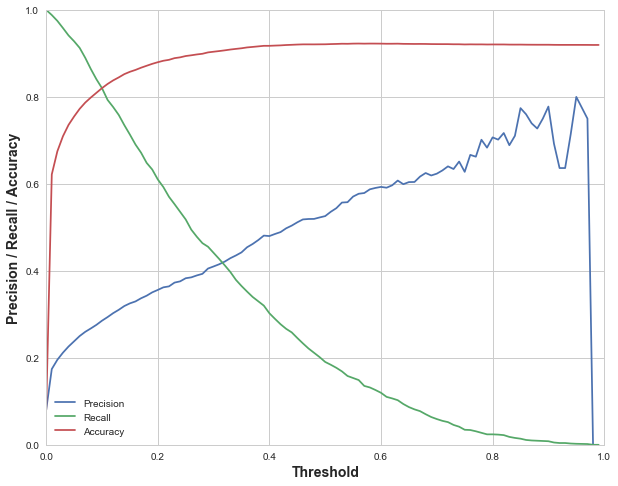

In [51]:
rf_cols =  ['loan_amount',  'latitude', 'longitude',
            'borrower_count', 'percentage_women', 
            'sector_percent_expired', 'activity_percent_expired',
            'country_percent_expired', 'country_total_loans', 
            'terms_repayment_term', 'tag_max_idf', 'tag_min_idf', 
            'description_word_count', 'knn_pred', 'nb_prob', 'nb_tag_prob',
           'already_disbursed']
        
rf_model = RandomForestClassifier(n_estimators=1000)
rf_model.fit(X_train.loc[:, rf_cols], y_train)

# predict class labels for the test set
y_test_pred_proba_rf = rf_model.predict_proba(X_test.loc[:, rf_cols])[:, 1]

model_name_rf = 'Random Forest'
recallvec_rf, precisionvec_rf, threshvec_rf, auc_score_rf, l_loss_rf = print_metrics(
    model_name_rf, y_test, y_test_pred_proba_rf)

order_zip_coeff(rf_cols, rf_model.feature_importances_) # 0.189820421888

## Gradient Boosting Classifier

---  Gradient Boosting Classifier  ---
AUC:  0.90220303858
Log Loss:  0.188890079097


[(0, ('nb_prob', 0.25111564824936283)),
 (1, ('loan_amount', 0.15107794958588758)),
 (2, ('description_word_count', 0.1236649555100048)),
 (3, ('country_total_loans', 0.07152563958293591)),
 (4, ('sector_percent_expired', 0.070754523850139153)),
 (5, ('terms_repayment_term', 0.067550052655678261)),
 (6, ('country_percent_expired', 0.06351272295115043)),
 (7, ('latitude', 0.036785849710957955)),
 (8, ('nb_tag_prob', 0.035146053159576064)),
 (9, ('tag_max_idf', 0.03225853736085587)),
 (10, ('percentage_women', 0.029453568371162812)),
 (11, ('longitude', 0.028263758344980728)),
 (12, ('tag_min_idf', 0.022257913270092695)),
 (13, ('borrower_count', 0.009326019226023512)),
 (14, ('nb_lsa_prob', 0.0073068081711915589))]

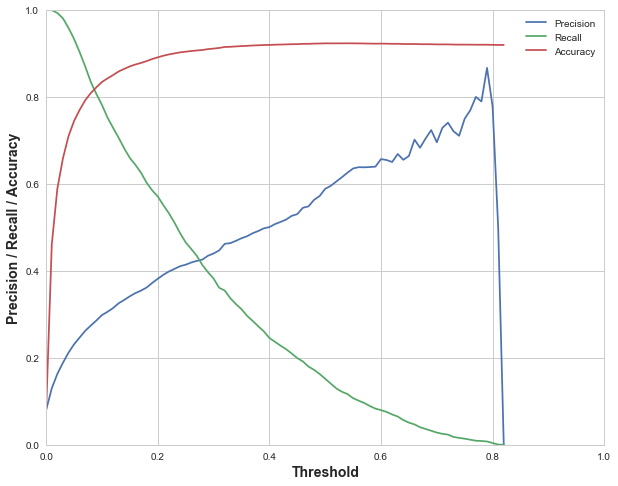

In [52]:
gb_cols =  ['loan_amount',  'latitude', 'longitude',
            'borrower_count', 'percentage_women', 
            'sector_percent_expired', 
            'country_percent_expired', 'country_total_loans', 
            'terms_repayment_term', 'tag_max_idf', 'tag_min_idf', 'description_word_count',
            'nb_prob', 'nb_lsa_prob', 'nb_tag_prob']

gb_model = GradientBoostingClassifier()
gb_model.fit(X_train.loc[:, gb_cols], y_train)
y_test_pred_proba_gb = gb_model.predict_proba(X_test.loc[:, gb_cols])[:, 1]

model_name_gb = 'Gradient Boosting Classifier'
recallvec_gb, precisionvec_gb, threshvec_gb, auc_score_gb, l_loss_gb = print_metrics (
    model_name_gb, y_test, y_test_pred_proba_gb)

order_zip_coeff(gb_cols, gb_model.feature_importances_) # 0.18883589195

## Logistic Regression

---  Logistic Regression  ---
AUC:  0.864197013326
Log Loss:  0.216276886271


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


[(0, ('knn_pred', 0.76768208014245842)),
 (1, ('nb_prob', 0.41841896856281452)),
 (2, ('sector_percent_expired', 0.33413627133802337)),
 (3, ('nb_tag_prob', 0.26829442234065909)),
 (4, ('already_disbursed', 0.18170122171149095)),
 (5, ('terms_repayment_term', 0.16727430560743675)),
 (6, ('loan_amount', 0.12380089958115671)),
 (7, ('nb_lsa_prob', 0.11236455348115508)),
 (8, ('tag_min_idf', -0.22335321523138588)),
 (9, ('tag_max_idf', -0.27235831346097378)),
 (10, ('percentage_women', -0.29027359738268182)),
 (11, ('description_word_count', -0.3250066585468791))]

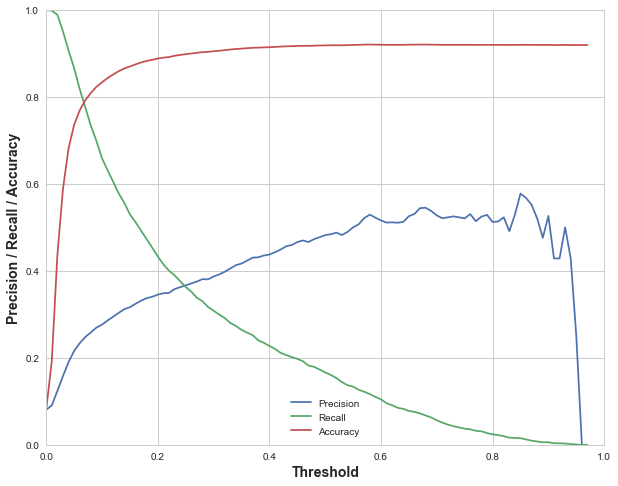

In [53]:
lr_cols = ['loan_amount', 'percentage_women',
           'knn_pred', 'sector_percent_expired',
           'terms_repayment_term', 
           'tag_max_idf', 'tag_min_idf', 'description_word_count', 
           'nb_prob', 'nb_lsa_prob', 'nb_tag_prob', 'already_disbursed']

std_lr = StandardScaler()
std_lr.fit(X_train.loc[:, lr_cols])

X_std_train_lr = std_lr.transform(X_train.loc[:, lr_cols])
X_std_test_lr = std_lr.transform(X_test.loc[:, lr_cols])

lr_model = LogisticRegression()
lr_model.fit(X_std_train_lr, y_train)
y_test_pred_proba_lr = lr_model.predict_proba(X_std_test_lr)[:, 1]

model_name_lr = 'Logistic Regression'
recallvec_lr, precisionvec_lr, threshvec_lr, auc_score_lr, l_loss_lr = print_metrics (
    model_name_lr, y_test, y_test_pred_proba_lr)

order_zip_coeff(lr_cols, lr_model.coef_[0]) # 0.21850343889



### Evaluate Logistic Regression with Regularization

In [54]:
lr_penalty_values = [10**e for e in range(-3, 5)]
lr_log_loss_scores = []
for penalty in lr_penalty_values:
    lr_log_loss_penalty = np.mean(cross_val_score(LogisticRegression(C=penalty), X_std_train_lr, y_train, cv=5, scoring='neg_log_loss'))
    lr_log_loss_scores.append(lr_log_loss_penalty)
    

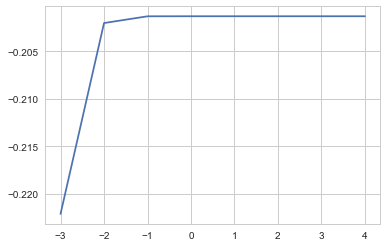

In [55]:
plt.plot(range(-3, 5), lr_log_loss_scores)

### Logistic Regression with Feature Selection
#### Cross Validation Error as Number of Features is increased:

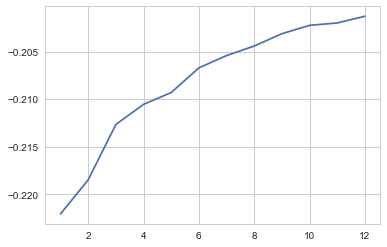

In [56]:
lr_log_loss_scores = []
for feature_count in range(1, len(lr_cols)+1):
    lr_rfe = RFE(LogisticRegression(), feature_count)
    lr_fit = lr_rfe.fit(X_std_train_lr, y_train)
    feature_p_logloss = np.mean(cross_val_score(lr_fit, X_std_train_lr, y_train, 
                                                cv=5, scoring='neg_log_loss'))
    lr_log_loss_scores.append(feature_p_logloss)

plt.plot(range(1, len(lr_cols)+1), lr_log_loss_scores)

## Ensemble Method

---  Ensemble  ---
AUC:  0.897069221812
Log Loss:  0.196437892251


/Users/nanawu/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


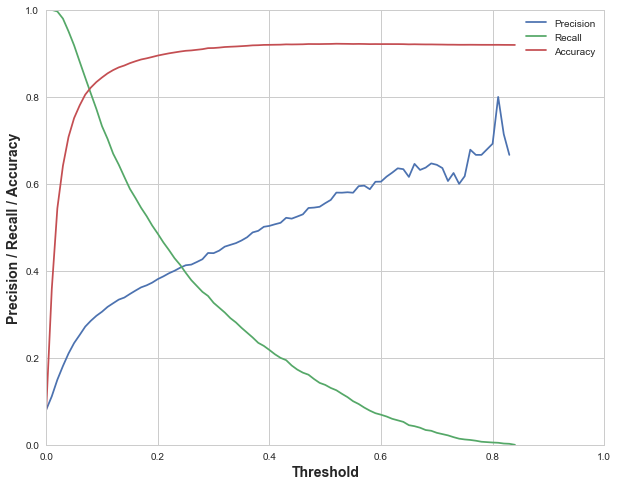

In [57]:
y_test_pred_proba_ensemble = (y_test_pred_proba_lr * y_test_pred_proba_gb)**(.5)

model_name_ensemble = 'Ensemble'
recallvec_ensemble, precisionvec_ensemble, threshvec_ensemble, auc_score_ensemble, l_loss_ensemble = print_metrics (
    model_name_ensemble, y_test, y_test_pred_proba_ensemble)

## Metrics

In [58]:
# Baseline Metrics
percentage_pos = np.mean(y_train)
percentage_neg = 1 - percentage_pos
baseline_logloss = -1 * ((percentage_pos * np.log(percentage_pos)) + ((1-percentage_neg) * np.log(percentage_neg)))
# starting from low entropy
print('Positive: {}%, Baseline Log Loss: {}'.format(percentage_pos * 100, baseline_logloss))

Positive: 8.053374455161997%, Baseline Log Loss: 0.20963263330049575


### Model Comparisons

,Model,Log Loss,Log Loss / Baseline Log Loss,AUC
0,Baseline,0.209633,1.000000,NaN
1,Gradient Boosting Classifier,0.188890,0.901053,0.902203
2,Random Forest,0.188754,0.900403,0.901838
3,Logistic Regression,0.216277,1.031695,0.864197


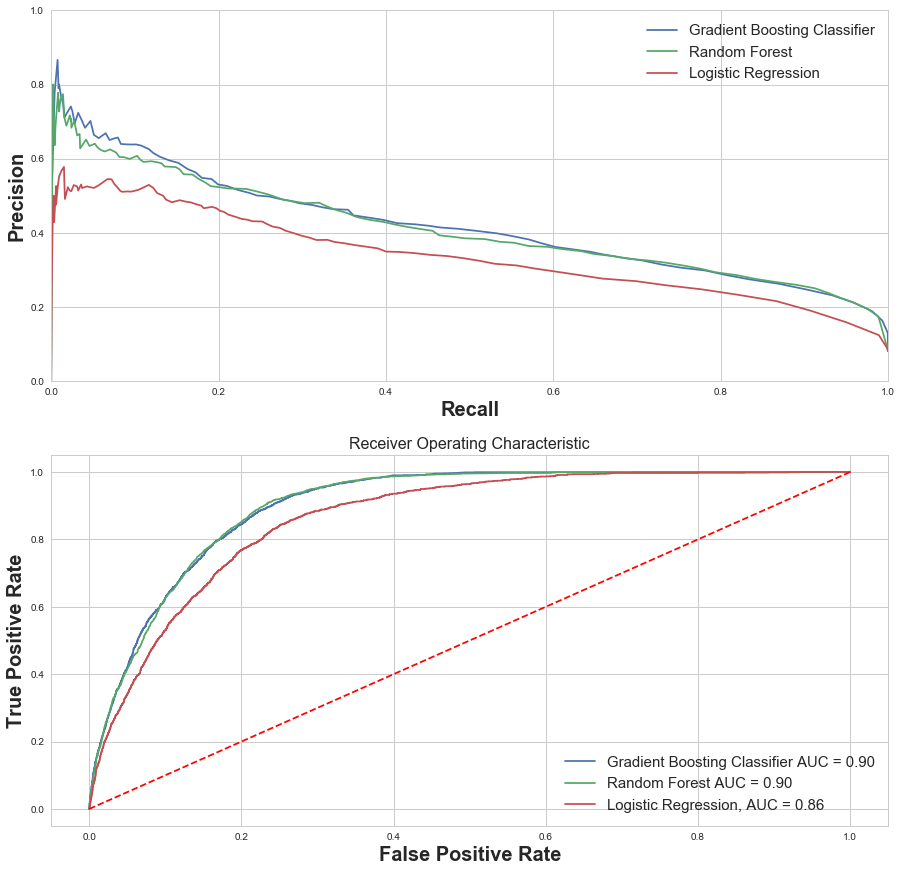

In [59]:
# ROC Curve
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_test, y_test_pred_proba_gb)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test, y_test_pred_proba_rf)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y_test, y_test_pred_proba_knn)
fpr_lr, tpr_lr, threshold_lr = roc_curve(y_test, y_test_pred_proba_lr)
fpr_ensemble, tpr_ensemble, threshold_ensemble = roc_curve(y_test, y_test_pred_proba_ensemble)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

# Precision Recall
ax[0].plot(recallvec_gb, precisionvec_gb, label=model_name_gb)
ax[0].plot(recallvec_rf, precisionvec_rf, label=model_name_rf)
ax[0].plot(recallvec_lr, precisionvec_lr, label=model_name_lr)

ax[0].axis([0, 1, 0, 1])
ax[0].set_ylabel("Precision", fontsize=20)
ax[0].set_xlabel("Recall", fontsize=20)
ax[0].legend(prop={'size': 15})

# ROC Curve
ax[1].set_title('Receiver Operating Characteristic')
ax[1].plot(fpr_gb, tpr_gb, label = 'Gradient Boosting Classifier AUC = %0.2f' % auc_score_gb)
ax[1].plot(fpr_rf, tpr_rf, label = 'Random Forest AUC = %0.2f' % auc_score_rf)
ax[1].plot(fpr_lr, tpr_lr, label = 'Logistic Regression, AUC = %0.2f' % auc_score_lr)

ax[1].legend(loc = 'lower right', prop={'size': 15})
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_ylabel('True Positive Rate', fontsize=20)
ax[1].set_xlabel('False Positive Rate', fontsize=20)

# Other Metrics:
df_metrics = pd.DataFrame({'Model': ['Baseline', model_name_gb, model_name_rf, 
                                     model_name_lr],
                           'Log Loss': [baseline_logloss, l_loss_gb, l_loss_rf, 
                                        l_loss_lr],
                           'Log Loss / Baseline Log Loss': [
                               1, (l_loss_gb / baseline_logloss),
                               (l_loss_rf / baseline_logloss), (l_loss_lr / baseline_logloss),],
                           'AUC': [np.nan, auc_score_gb, auc_score_rf, auc_score_lr]})
df_metrics[['Model', 'Log Loss', 'Log Loss / Baseline Log Loss', 'AUC']]

In [79]:
y_test_pred_abs_gb = [p > 0.1 for p in y_test_pred_proba_gb]
cm = confusion_matrix(y_test, y_test_pred_abs_gb, labels=[1, 0])
cm

array([[ 1333,   373],
       [ 3136, 16342]])

In [60]:
df[df.status == 'expired']['id'].map(lambda loan_id: 'https://www.kiva.org/lend/' + str(loan_id))[:5]

276    https://www.kiva.org/lend/1033039
378    https://www.kiva.org/lend/1033678
389    https://www.kiva.org/lend/1034035
502    https://www.kiva.org/lend/1034584
504    https://www.kiva.org/lend/1034593
Name: id, dtype: object